# Jupyter - Day 21 - Section 002
# Lec 21 - Polynomial Regression and Step Functions

In this module we are going to implement polynomial regression and step functions as discussed in class.

In [2]:
# Everyone's favorite standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline


# ML imports we've used previously
# import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures



# 0. Loading in the data

We're going to use the `Wage` data used in the book, so note that many of your plots can be checked by looking at figures in the book.

In [3]:
df = pd.read_csv('../data/Wage.csv', index_col =0 )
df.head()

,year,age,sex,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
231655,2006,18,1. Male,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
86582,2004,24,1. Male,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
161300,2003,45,1. Male,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
155159,2003,43,1. Male,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
11443,2005,50,1. Male,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3000 entries, 231655 to 453557
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   year        3000 non-null   int64  
 1   age         3000 non-null   int64  
 2   sex         3000 non-null   object 
 3   maritl      3000 non-null   object 
 4   race        3000 non-null   object 
 5   education   3000 non-null   object 
 6   region      3000 non-null   object 
 7   jobclass    3000 non-null   object 
 8   health      3000 non-null   object 
 9   health_ins  3000 non-null   object 
 10  logwage     3000 non-null   float64
 11  wage        3000 non-null   float64
dtypes: float64(2), int64(2), object(8)
memory usage: 304.7+ KB


In [5]:
df.describe()

,year,age,logwage,wage
count,3000.000000,3000.000000,3000.000000,3000.000000
mean,2005.791000,42.414667,4.653905,111.703608
std,2.026167,11.542406,0.351753,41.728595
min,2003.000000,18.000000,3.000000,20.085537
25%,2004.000000,33.750000,4.447158,85.383940
50%,2006.000000,42.000000,4.653213,104.921507
75%,2008.000000,51.000000,4.857332,128.680488
max,2009.000000,80.000000,5.763128,318.342430


Here's the plot we used multiple times in class to look at a single variable:  `age` vs `wage`. I've also added some splits so that the people making above and below $250,000 are drawn in a different color.

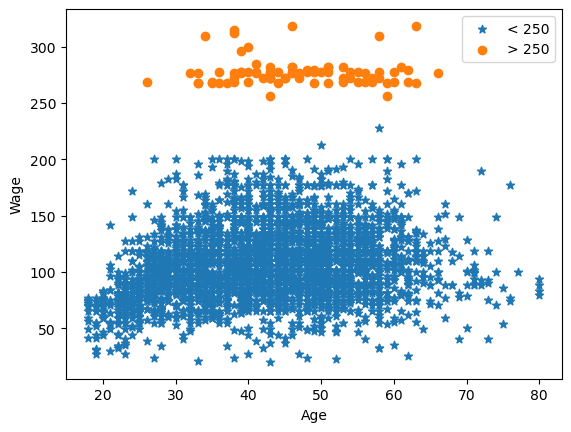

In [4]:
plt.scatter(df.age[df.wage <=250], df.wage[df.wage<=250],marker = '*', label = '< 250')
plt.scatter(df.age[df.wage >250], df.wage[df.wage>250], label = '> 250')
plt.legend()

plt.xlabel('Age')
plt.ylabel('Wage')
plt.show()

## 1. Linear Regression

Before we do anything fancy, let's just do some linear regression. It's not going to be a great fit to our data, this is just to see how we can draw the function learned. 

If I want to learn a linear model predicting `wage` from `age`, I can do the same thing we've done for the last month. 



In [5]:
from sklearn.linear_model import LinearRegression

In [6]:
X = df.age.values.reshape(-1,1)
y = df.wage

linreg = LinearRegression()

linreg.fit(X,y)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


&#9989; **<font color=red>Do this:</font>** What is the equation learned by the model? 

In [7]:
linreg.coef_

array([0.70727593])

In [8]:
linreg.intercept_

np.float64(81.70473544394635)

y=0.70727593*x+81.70473544394635

Now I could plot this by taking the equation I just learned and applying it to some vector of values. However, it is even easier to do this by simply predicting the outputs for a lot of the $x$-inputs and then drawing the function on top of the data.  

&#9989; **<font color=red>Do this:</font>** Use the `predict` function to get the function outputs and then plot this using the code below. 

In [9]:
t_age = np.linspace(20,80, 100).reshape(-1,1)

# your code here for y_wage
y_wage = t_age*linreg.coef_+linreg.intercept_


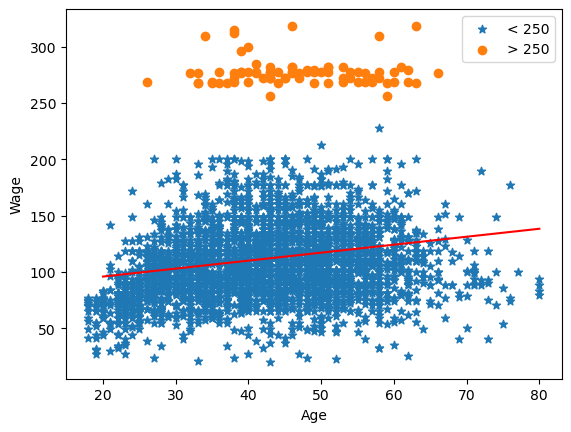

In [10]:
# If you edit the y_wage stuff above, you'll get the linear regression line drawn here.


# This is all the stuff to plot the data
plt.scatter(df.age[df.wage <=250], df.wage[df.wage<=250],marker = '*', label = '< 250')
plt.scatter(df.age[df.wage >250], df.wage[df.wage>250], label = '> 250')
plt.legend()

plt.xlabel('Age')
plt.ylabel('Wage')

# This is what I'm adding to draw the line 
plt.plot(t_age, y_wage, color = 'red')
plt.show()

# 1. Polynomial Regression 

Our first step is to build a polynomial regression model using the age data to predict wage.  So, as in class, we are in $p=1$ world here where we are going to fit the model
$$
\texttt{wage} = \beta_0 + \beta_1 \texttt{age} + \beta_2 \texttt{age}^2 + \cdots + \beta_p \texttt{age}^p +\varepsilon.
$$

The trick here is to build a matrix $X$ which has a column containing `age`, one with `age^2`, one with `age^3`, etc.  Then we hand this to your favorite regression tool (it doesn't need to know it's getting polynomial matrix inputs, it just sees a matrix of features and does it's thing). 

Here's the code we learned in [Lecture 14](../../14-Ch5_1-More_KFoldCV/index.md) for building the data frame of powers of input $X$. 

In [11]:
p = 4
poly = PolynomialFeatures(p, include_bias = False)
X_powers = poly.fit_transform(X)

# X_powers

model = LinearRegression()
model.fit(X_powers,y)
print(f"Coefs: {model.coef_}")
print(f"Intercept: {model.intercept_}")

Coefs: [ 2.12455205e+01 -5.63859313e-01  6.81068771e-03 -3.20383037e-05]
Intercept: -184.1541797734385


&#9989; **<font color=red>Do this:</font>** What is the equation of the model learned?  

y=-184.15+21.25x-0.56x^2+0.00681x^3-0.00003204x^4

&#9989; **<font color=red>Do this:</font>** As before, in order to plot we want to determine `y_wage` from the `t_age` input below by using the `predict` command. However, note that to do this, you're going to have to pass in the polynomial matrix for the `t_age` column.  

In [12]:
t_age = np.linspace(10,90,100).reshape(-1,1)

# Make the polynomial features from t_age 
t_powers = poly.transform(t_age)

# Now predict the y values from the model and the t_powers
y_wage = model.predict(t_powers)

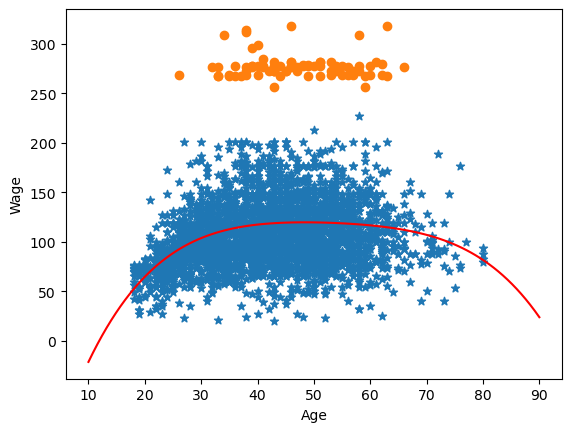

In [13]:
# Note: this should look like slide from class.
plt.scatter(df.age[df.wage <=250], df.wage[df.wage<=250],marker = '*')
plt.scatter(df.age[df.wage >250], df.wage[df.wage>250])

plt.xlabel('Age')
plt.ylabel('Wage')

plt.plot(t_age, y_wage, c= 'red')
plt.show()

# 2. Step functions

Now let's try to use step functions to learn a model using `age` to predict `wage`. Like with the polynomial example from last time, all we're going to do is build a data frame or feature matrix that has the step function values in each column, and then pass that matrix to our favorite linear modeling function. 

First, we want to get a dataframe with the cuts. 

In [ ]:
df_cut, bins = pd.cut(df.age, 4, retbins = True, right = False)

Note that the `df_cut` is a pandas series with each data point now represented as the interval it's contained in. 

In [ ]:
df_cut

Here I'm just printing it out in a column next to the `age` information that was used to generate it.

In [ ]:
pd.DataFrame({'age': df.age, 'df_cut': df_cut}).head(10)

The `bins` output gives me the $c_i$ knots as follows. 


In [ ]:
print(bins)

In [ ]:
# This is how it matches with our notation.
print(r'c_1 = ', bins[0])
print(r'c_2 = ', bins[1])
print(r'c_3 = ', bins[2])
print(r'c_4 = ', bins[3])
print(r'c_5 = ', bins[4])

&#9989; **<font color=red>Do this:</font>**
 For each of the functions $C_0(X)$, $C_1(X)$, $C_2(X)$, $C_3(X)$, $C_4(X)$, $C_5(X)$ (following our notation in class), determine the domains where they have value 1. 

*Your answer here*

- $C_0(X)$:
- $C_1(X)$:
- $C_2(X)$: 
- $C_3(X)$: 
- $C_4(X)$: 
- $C_5(X)$: 

We can use the dummy variable trick to turn the `df_cut` output into something closer to what we are using. Below is my code that generates the data frame storing $C_i(X)$ for all our entries. 

In [ ]:
df_steps_dummies = pd.get_dummies(df_cut) # This gives us entries with true/false
df_steps = df_steps_dummies.apply(lambda x: x * 1) # This converts those to either 0 or 1.
df_steps

&#9989; **<font color=red>Q:</font>** Which of the functions $C_i(X)$ for $i=0,\cdots, 5$ have columns represented in this matrix? *Note: it's not all of them*


* Your answer here*

&#9989; **<font color=red>Do this:</font>** Pass this matrix to a linear regression model and use it to predict `wage`. What is the equation for your learned model? Be specific in terms of the $C_i$ functions you learned earlier.

In [ ]:
# Your code here #

Assuming you stored your linear regression model as `linreg`, the following code will plot the learned function. Check that the answers you got in the table above match with what you're seeing in the graph.  

In [ ]:
t_age = pd.Series(np.linspace(20,80,100))
t_df_cut = pd.cut(t_age, bins, right = False) #<-- I'm explicitly passing the same bins learned above so tha the procedure is the same. 

t_dummies = pd.get_dummies(t_df_cut)
t_step = t_dummies.apply(lambda x: x * 1)

t_step.head()

&#9989; **<font color=red>Do this:</font>** Above, I figured out the transformation of the input `t_age` values to do the same transformation as our step function. Now use the linear regression model learned to predict `y_wage`, then we can graph it. 

In [ ]:
# your code here

# y_wage = .......

In [ ]:
plt.scatter(df.age[df.wage <=250], df.wage[df.wage<=250],marker = '*')
plt.scatter(df.age[df.wage >250], df.wage[df.wage>250])
plt.xlabel('Age')
plt.ylabel('Wage')

plt.plot(t_age, y_wage,color='red')
plt.show()



-----
### Congratulations, we're done!
Initially created by Dr. Liz Munch, adapted by Dr. Mengsen Zhang, Michigan State University

<a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/">Creative Commons Attribution-NonCommercial 4.0 International License</a>.